We train a `sklearn` `RandomForest` model, then create a Shparkley wrapper implementing the Shparkley API. 

This demonstrator shows that Shparkley works with any model that can implement the wrapper class and which can generate predictions given a dataset in local (to each executor) memory.


# Load Spark Kernel
Using `findspark`, but many other ways exist too. See ([Installing Spark](https://spark.apache.org/downloads.html))

In [1]:
import seaborn as sns
from tempfile import mktemp
from os import system

import findspark
findspark.init() #  Adds `pyspark` to `sys.path` at runtime
import pyspark
from pyspark.sql import Row, SQLContext
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_graphviz


from IPython.display import display, Image
from sklearn.base import ClassifierMixin
from typing import Any, Dict, List, Set


from affirm.model_interpretation.shparkley.spark_shapley import (
    compute_shapley_for_sample,
    ShparkleyModel,
)

In [2]:
pyspark.__version__

'3.0.1'

In [3]:
! echo $JAVA_HOME

/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home


In [4]:
! echo $SPARK_HOME

/usr/local/spark


Create connection to Spark cluster

In [5]:
sc = pyspark.SparkContext(appName="shparkley_example")

In [6]:
sql_context = SQLContext(sc)

## Verify it's started 

In [7]:
! jps -lvm | grep -i spark

26784 org.apache.spark.deploy.SparkSubmit pyspark-shell -Xmx1g


 `org.apache.spark.deploy.SparkSubmit pyspark-shell` is running -- looks good. 

[Look more at configuration:](https://spark.apache.org/docs/latest/cluster-overview.html)
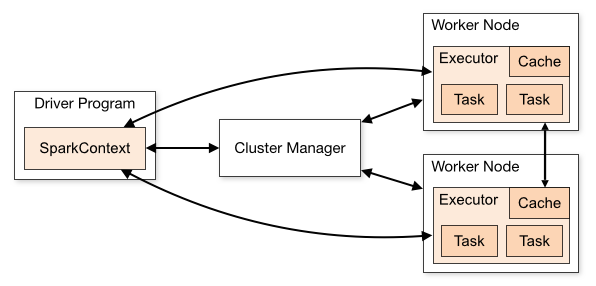

In [8]:
sc.getConf().getAll()

[('spark.driver.port', '57402'),
 ('spark.app.name', 'shparkley_example'),
 ('spark.driver.host', '192.168.1.2'),
 ('spark.app.id', 'local-1603071412050'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [9]:
sc.defaultParallelism, sc.defaultMinPartitions

(8, 2)

This means that by default, `pyspark.DataFrame`s will be created with 8 partitions. 

This is because `sc.parallelize` [here (link)](https://github.com/apache/spark/blob/97605cd1269987ed5ba3013a5f8497375ce8913e/python/pyspark/sql/session.py#L452) is used to convert from local-memory `DataFrame` which uses its `defaultParallelism`. 

There is [no obvious way](https://stackoverflow.com/a/28793407/588437) to get the number of [**executors**](https://spark.apache.org/docs/latest/cluster-overview.html) from the `pyspark` API. 


# Load Sample Dataset

In [10]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [11]:
iris['species'].value_counts()

setosa        50
virginica     50
versicolor    50
Name: species, dtype: int64

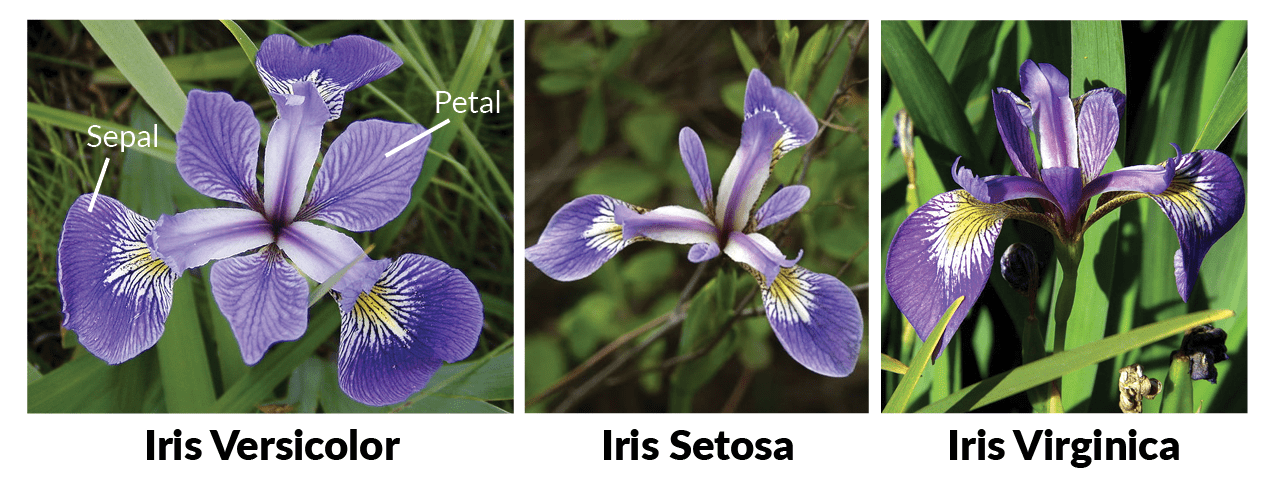 [source](https://www.datacamp.com/community/tutorials/machine-learning-in-r)

## Get rid of Versicolor for simplicity (So we can do a 2-class classification instead of a 3-class one)

In [12]:
iris_no_vers = iris[
    iris['species'] != 'versicolor'
]    

In [13]:
TARGET_ENCODING = {'setosa': 0.0, 'virginica': 1.0}
REV_TARGET_ENCODING = {v:k for (k, v) in TARGET_ENCODING.items()}

In [14]:
iris_no_vers.loc[:, 'species'].replace(TARGET_ENCODING, inplace=True)

/Users/ijoseph/opt/miniconda3/envs/3.8/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


# Fit Sample Model

In [15]:
N_ESTIMATORS = 3

In [16]:
pd.np.random.seed(42)
train, test = train_test_split(iris_no_vers)

<ipython-input-16-73deddc6d6a6>:1: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.random.seed(42)


In [17]:
train.shape, test.shape

((75, 5), (25, 5))

In [18]:
random_forest_classifier = RandomForestClassifier(n_estimators=N_ESTIMATORS)

In [20]:
fitted_model = random_forest_classifier.fit(X=train.drop('species', axis=1), y=train['species'])

## Sanity-Check Fit

In [21]:
roc_auc_score(y_true=test['species'], y_score=fitted_model.predict(test.drop('species', axis=1)))

1.0

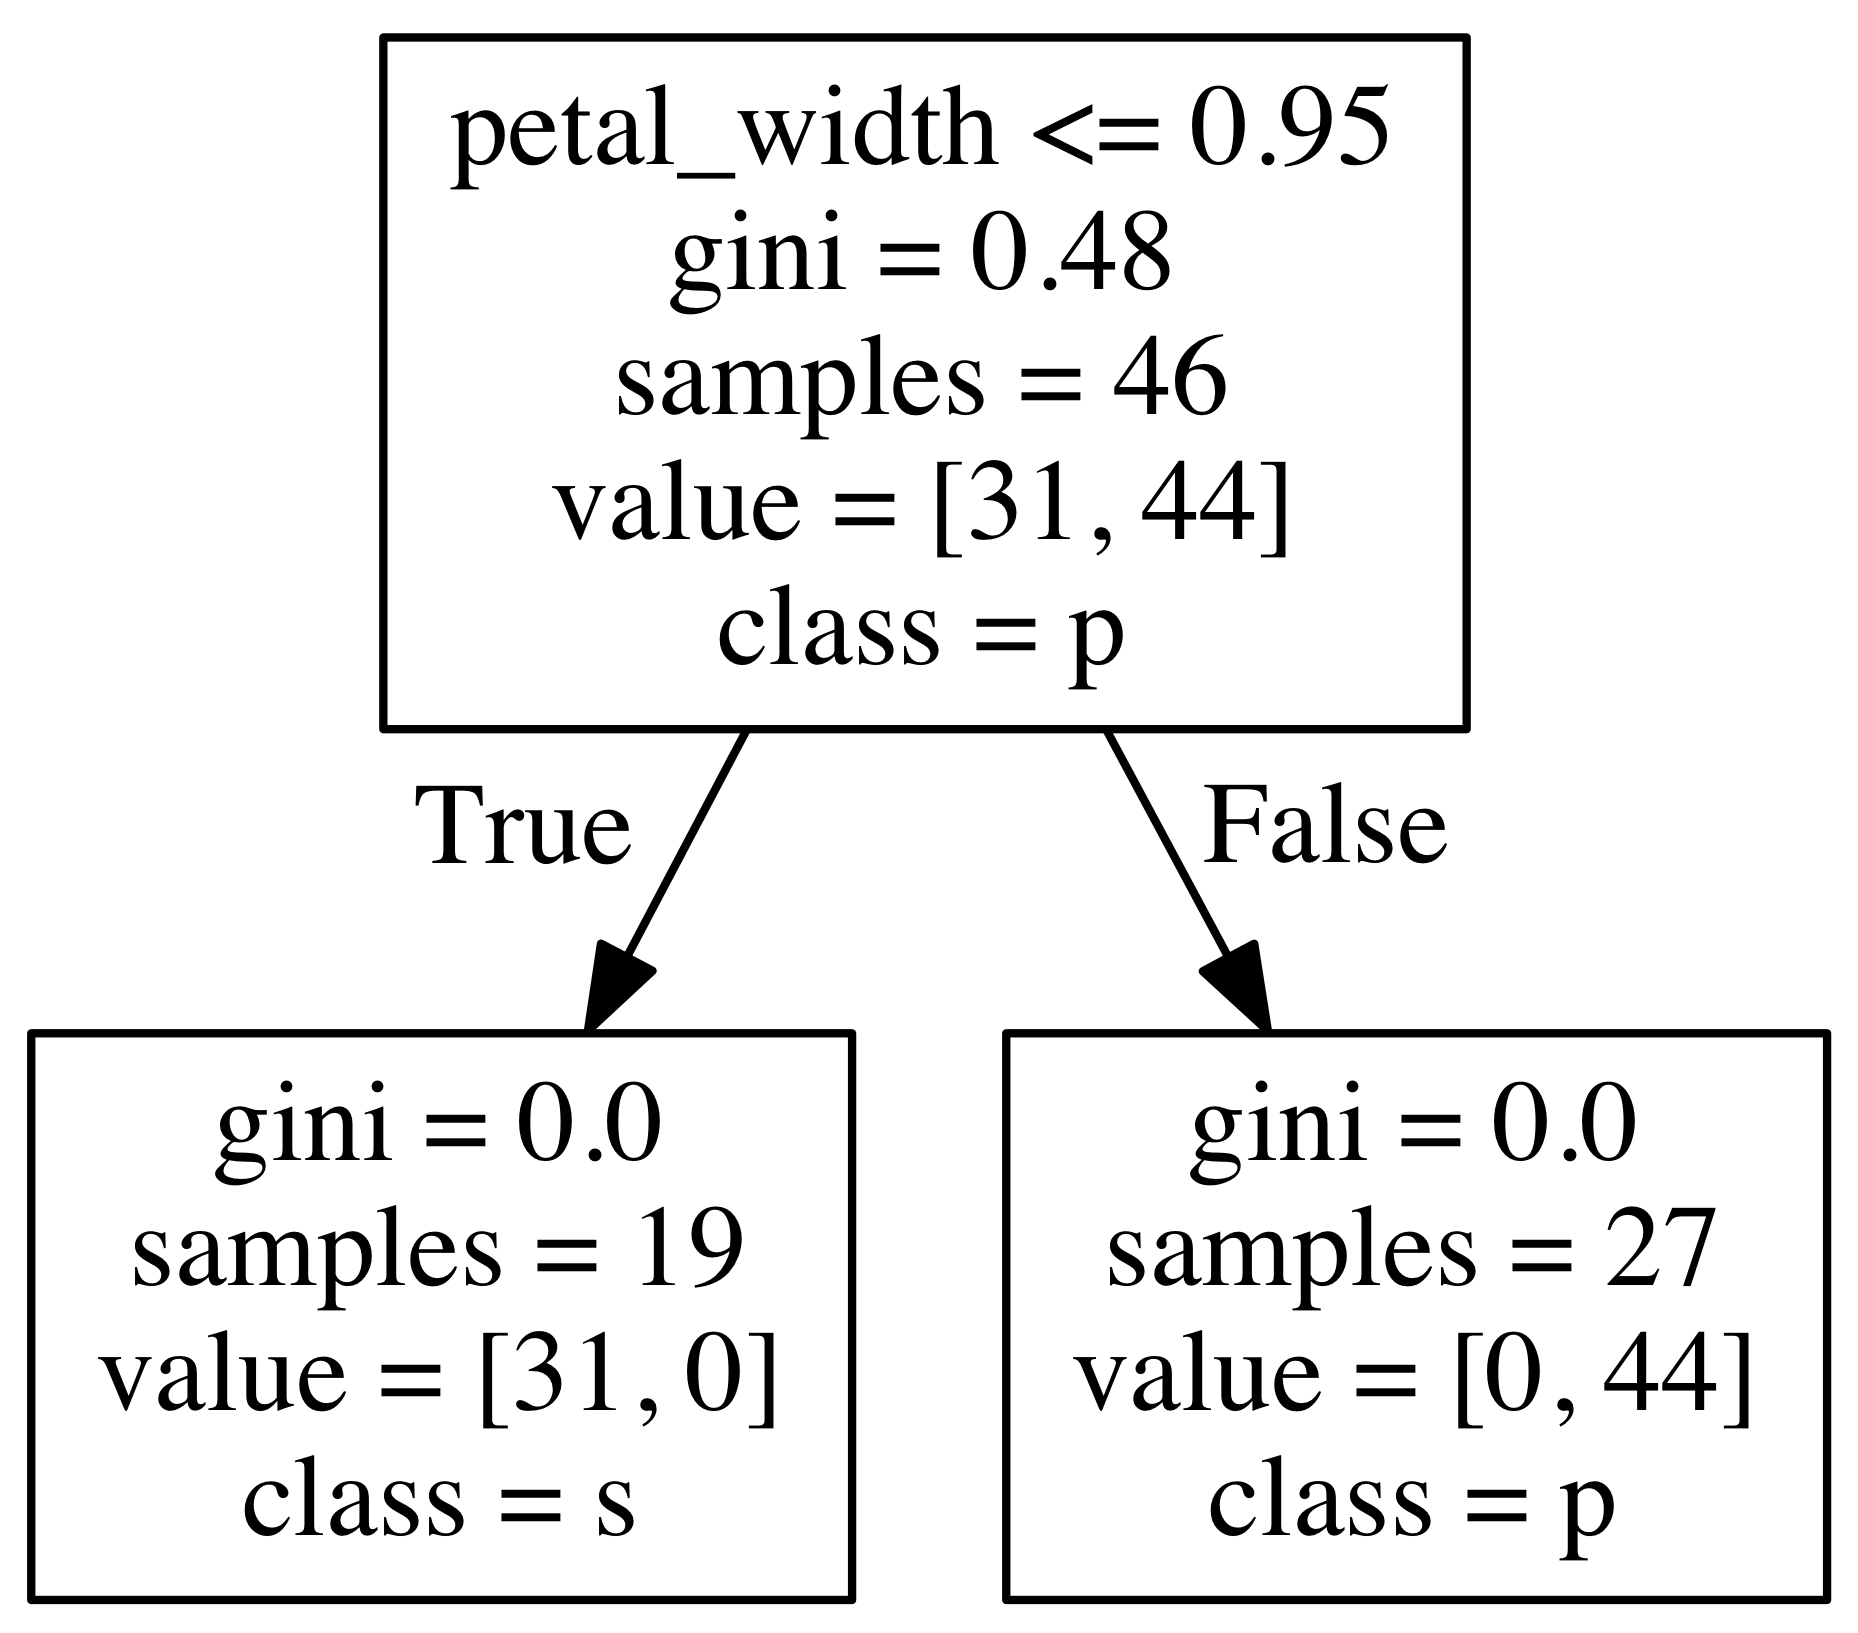

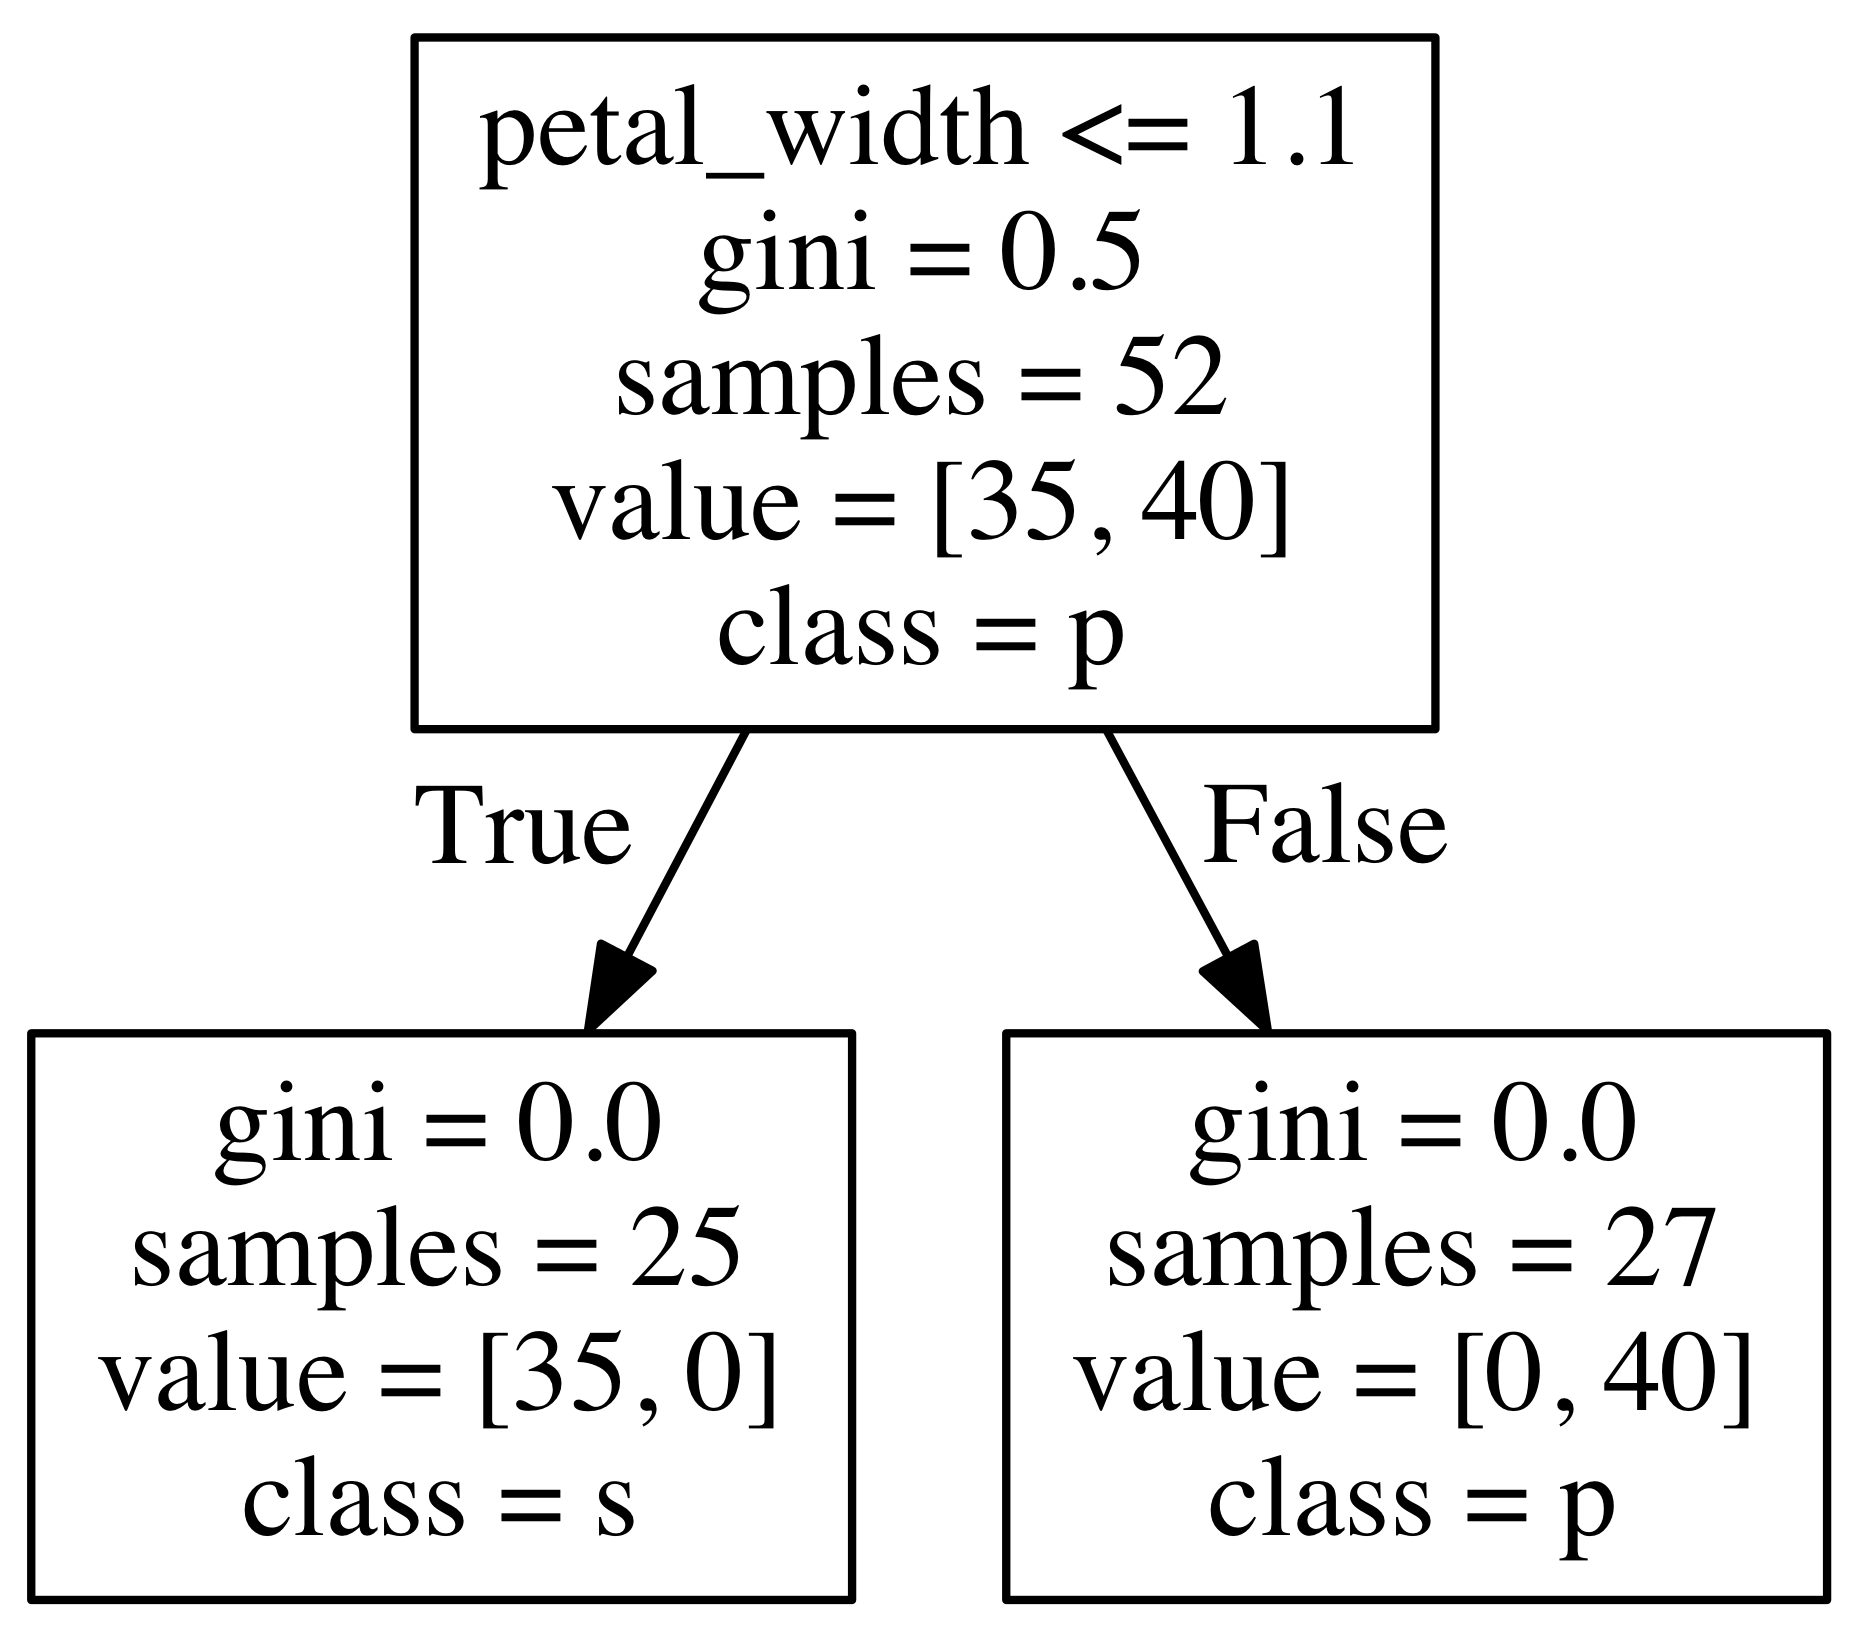

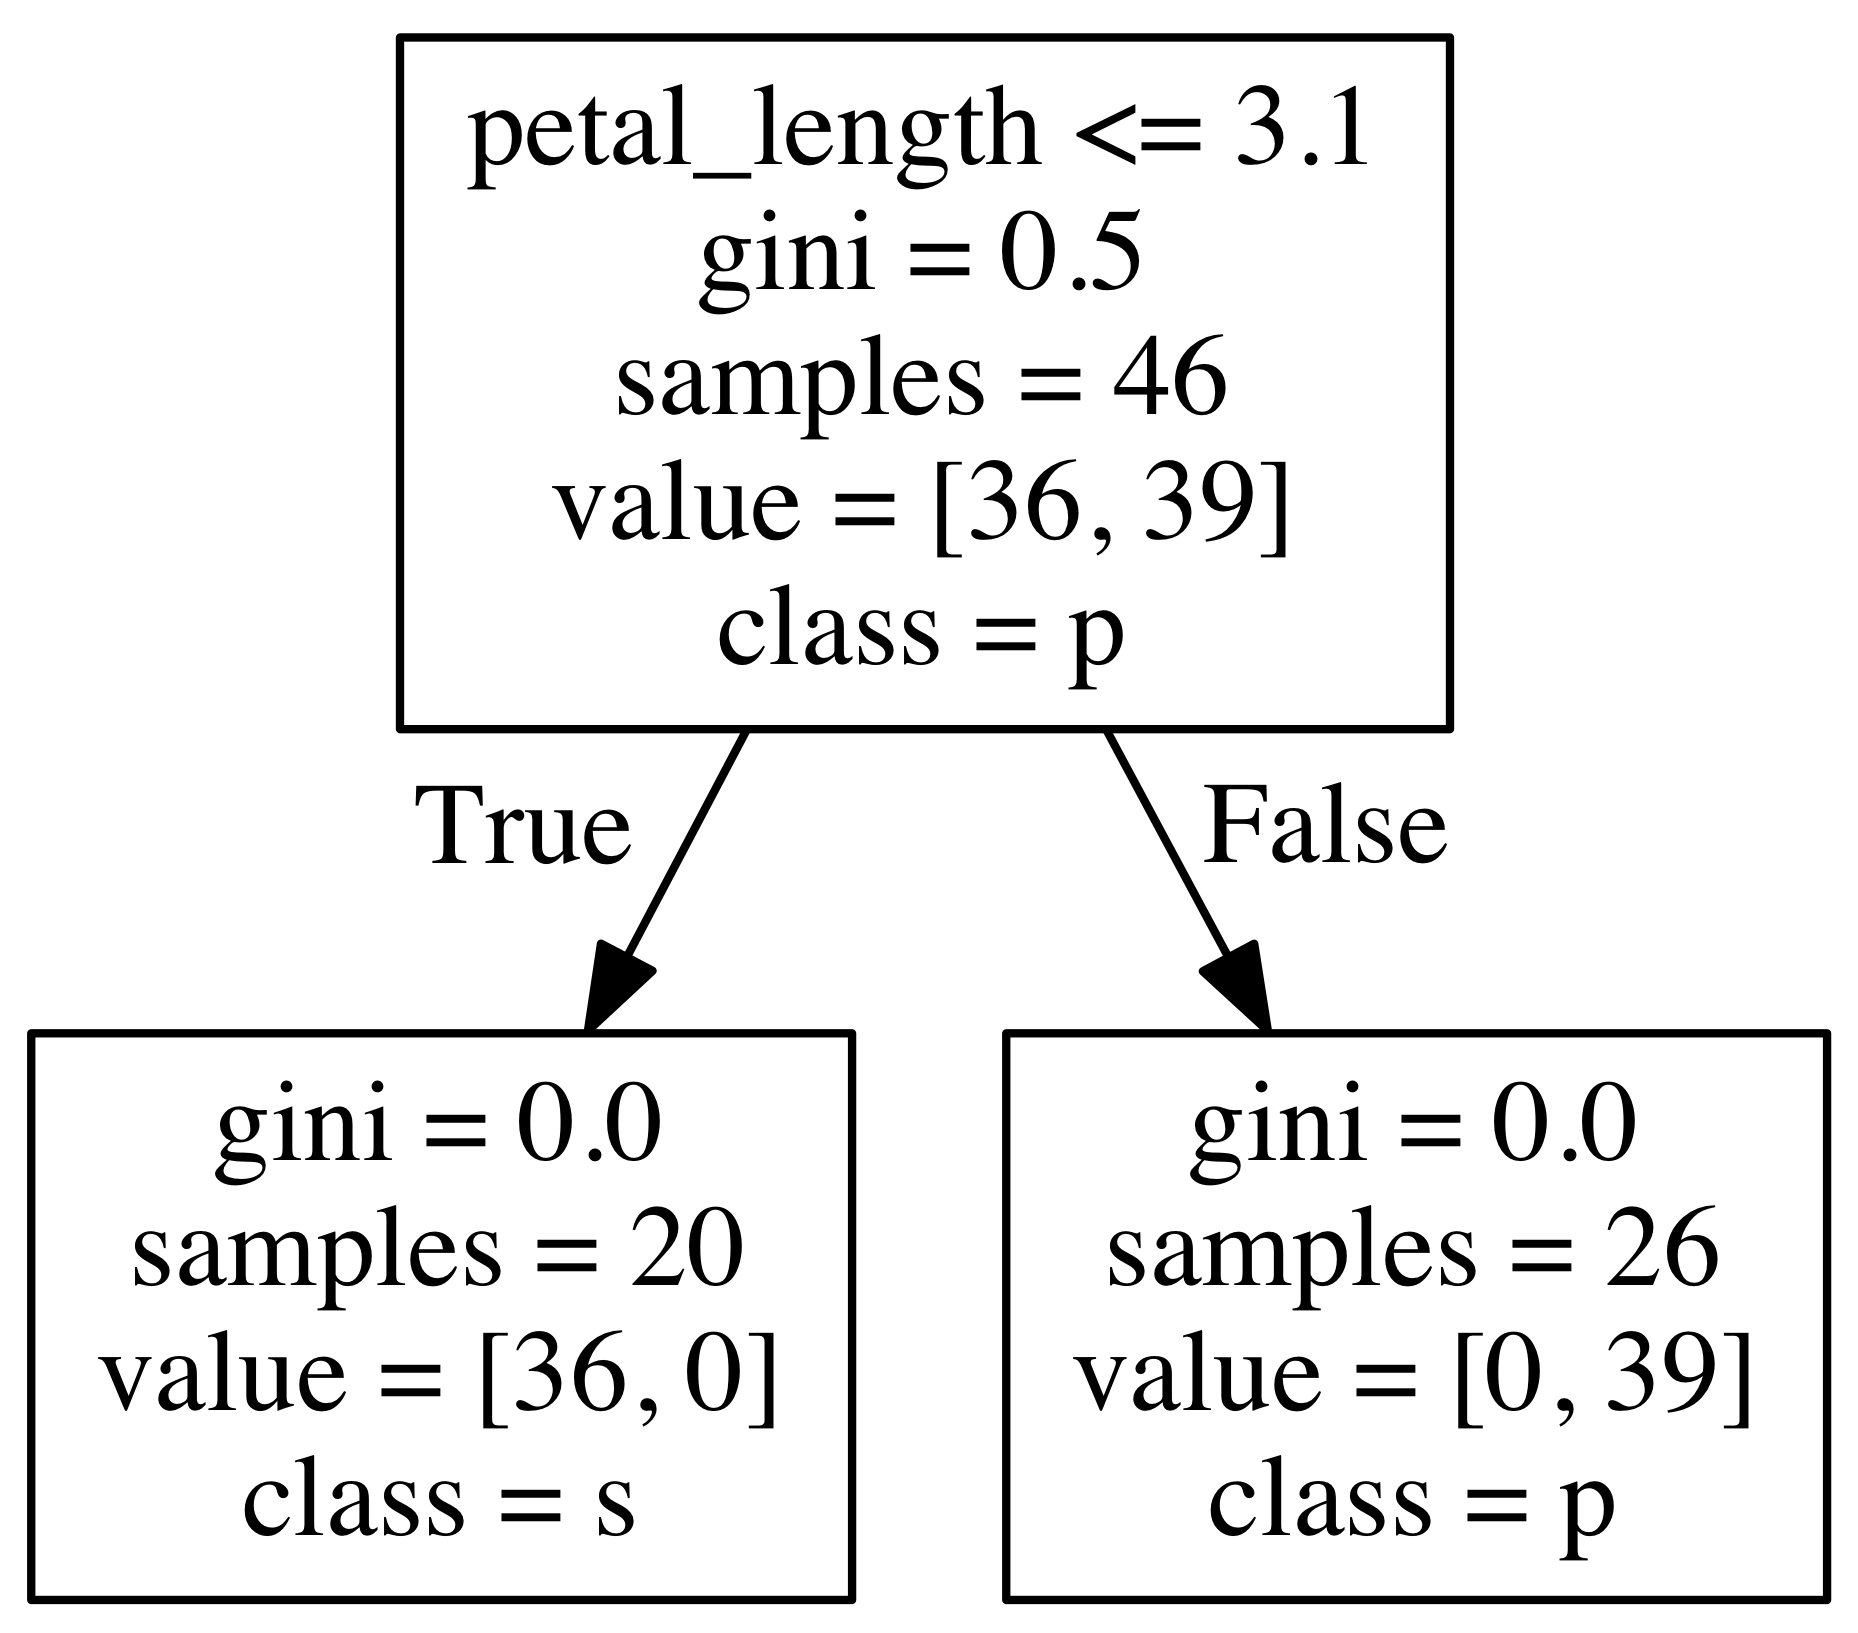

In [22]:
images = []
for estimator in fitted_model.estimators_:
    dot_file = mktemp(suffix='.dot')
    png_file = mktemp(suffix='.png')
    export_graphviz(estimator, out_file=dot_file, feature_names = iris_no_vers.columns[:4], class_names='species', precision=2)
    system(f'dot -Tpng {dot_file} -o {png_file} -Gdpi=600')
    images.append(Image(png_file, width=300))

display(*images)

<AxesSubplot:xlabel='petal_length', ylabel='species'>

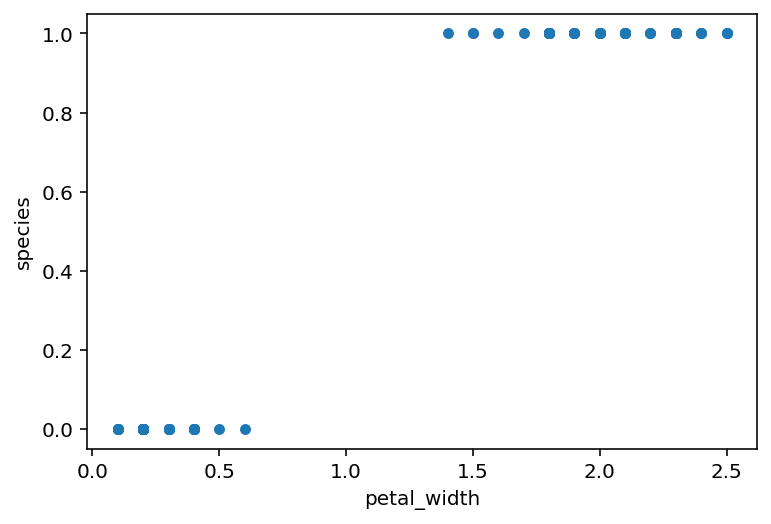

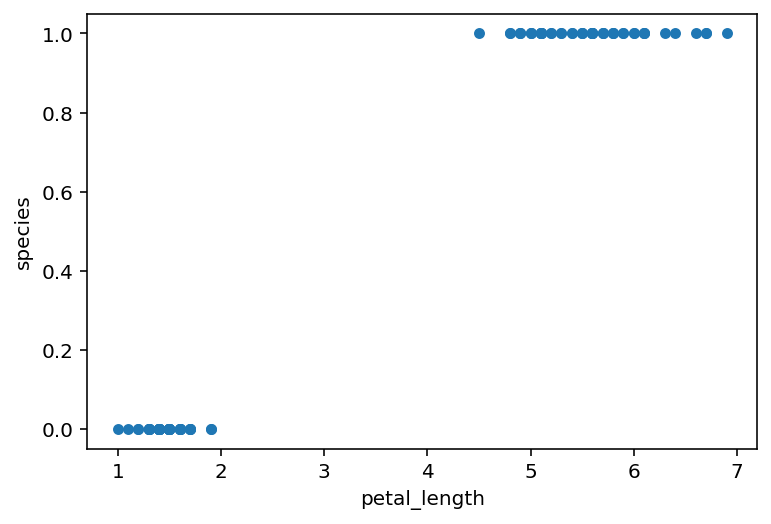

In [23]:
iris_no_vers.plot.scatter(x='petal_width', y='species')
iris_no_vers.plot.scatter(x='petal_length', y='species')

Seems reasonable. Basically a degenerate forest which has trees that can either be petal width or petal length, both of which are perfect classifiers on their own. 

# Explain with Shapley

Create wrapper class

In [24]:
class MyShparkleyModel(ShparkleyModel):
    def __init__(self, model: ClassifierMixin, required_features: Set[str]):
        self._model = model
        self._required_features = set(required_features)

    def predict(self, feature_matrix: List[Dict[str, Any]]) -> List[float]:
        pd_df = pd.DataFrame.from_dict(feature_matrix)
        preds = self._model.predict(pd_df)
        return preds

    def get_required_features(self) -> Set[str]:
        return self._required_features

In [25]:
model_with_shparkley_interface = MyShparkleyModel(
    model=fitted_model, required_features=iris_no_vers.columns[:4]
)

## Sanity Check of Wrapper API

In [26]:
model_with_shparkley_interface.get_required_features()

{'petal_length', 'petal_width', 'sepal_length', 'sepal_width'}

In [27]:
test.iloc[0:1, 0:4].to_dict()

{'sepal_length': {133: 6.3},
 'sepal_width': {133: 2.8},
 'petal_length': {133: 5.1},
 'petal_width': {133: 1.5}}

In [28]:
model_with_shparkley_interface.predict(test.iloc[0:1, 0:4].to_dict())

array([1.])

## Explain Some Test Datapoints

### Load Training DataFrame into Spark

In [29]:
sql_context = SQLContext(sc)

In [30]:
train_spark_df = sql_context.createDataFrame(train)

In [36]:
train_spark_df.rdd.getNumPartitions()

8

As foreshadowed by earlier `defaultParallelism`

In [31]:
train_spark_df.describe().show()

+-------+------------------+-------------------+------------------+------------------+------------------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|           species|
+-------+------------------+-------------------+------------------+------------------+------------------+
|  count|                75|                 75|                75|                75|                75|
|   mean|5.8293333333333335|  3.198666666666667| 3.613333333333334|1.1920000000000002|              0.52|
| stddev|0.9721491006393382|0.41508492564232624|2.1224242471015744|0.9384806582694958|0.5029641865709455|
|    min|               4.3|                2.3|               1.1|               0.1|               0.0|
|    max|               7.9|                4.4|               6.9|               2.5|               1.0|
+-------+------------------+-------------------+------------------+------------------+------------------+



### Explain the First Test Datapoint

In [78]:
query_row = Row(**test.iloc[4,:].to_dict())
query_row

Row(sepal_length=5.1, sepal_width=3.8, petal_length=1.9, petal_width=0.4, species=0.0)

In [73]:
fitted_model.predict(test.iloc[2:3, :].drop("species", axis=1))

array([1.])

In [74]:
REV_TARGET_ENCODING

{0.0: 'setosa', 1.0: 'virginica'}

Why was this correctly predicted to be virginicia? 

In [79]:
compute_shapley_for_sample(
    df=train_spark_df,
    model=model_with_shparkley_interface,
    row_to_investigate=query_row,
)

{'petal_width': 0.0,
 'sepal_width': 0.0,
 'petal_length': 0.0,
 'sepal_length': 0.0}

who knows. 